<a href="https://colab.research.google.com/github/champigon1/cap-comp215/blob/main/PROJECT_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project 2**

### Name - SUKHMANDEEP SINGH KALRA
### Date - *2024-04-09*

### A Simple Grazing Model

---
The Forest Fire model is an example of how ecosystem processes can be modelled with Cellular Automata. Another simple ecosystem process is grazing – the cycle of herbivores eating vegetation, which regenerates between https://en.wikipedia.org/wiki/Grazing_(behaviour)

MODULES


In [31]:
%matplotlib inline

import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation
from scipy.signal import correlate2d
import random
import time
from scipy.spatial import distance
import timeit
from IPython.display import clear_output
random.seed(time.time())
'''Configure matplotlib's animation library to work in the browser.'''
matplotlib.rc('animation', html='jshtml')

##HELPERS
I HAVE TAKEN THIS CODE FROM THE LABS

In [32]:
DEFAULT_DISPLAY_OPTIONS = dict(
    cmap='Blues',
    interpolation='none',
    origin='upper',
)

def display_2D_matrix(matrix, ax=None, title='', **options):
    """ Display the 2D matrix as an image on the given axes. 1's will be dark blue, 0's will be light blue. """
    ax = ax or plt.gca()
    ax.set_title(title)
    ax.set_xticks([], [])
    ax.set_yticks([], [])
    options = {**DEFAULT_DISPLAY_OPTIONS, **options}
    ax.imshow(matrix, **options)



In [33]:
class MatrixAnimation:
    """
      Animates any 2D model by iterating through model updates and visualizations using matplotlib.
    """

    def __init__(self, model, total_frames=50, updates_per_frame=1, plot_size=(8, 8)):
        self.model = model
        self.total_frames = total_frames
        self.updates_per_frame = updates_per_frame
        self.figure, self.axis = plt.subplots(figsize=plot_size)

    def update_animation(self, frame_number):
        if frame_number > 0:
            for _ in range(self.updates_per_frame):
                self.model.update()
        self.model.visualize(self.axis, frame=frame_number * self.updates_per_frame)

    def render(self):
        anim = animation.FuncAnimation(self.figure, self.update_animation, frames=self.total_frames)
        plt.close()
        return anim

    def play_animation(self, delay=None):
        try:
            for frame in range(self.total_frames):
                clear_output(wait=True)
                self.axis.clear()
                plt.figure(self.figure)
                self.update_animation(frame)
                plt.show()
                if delay:
                    time.sleep(delay)
        except KeyboardInterrupt:
            pass

SIMPLE GRAZING MODEL
#Creating the Grazing 2D CA class.This class takes in several parameters including the size of the grid, the number of deer to start with, the regeneration rate of the grass, the maximum weight of each deer.

---


### Rules



1.   N deer are introduced onto a grassland which contains grass in ratio of grass_ratio
2. deer move to neighbour cell in direction to its closest grass.
3. The deer eat the grass which 'regrows' with probability 'regen_rate' after a short interval.
4. Each deer has a weight and max weight it can gain. M is the limit that generally a deer can have maximum weight.
5. when deer's weight is less than M,it eats grass when move to next cell which increase oits weight by 1 whereas if it doesnt find the grass in next cell weight decreases by 1.
6. If deer's weight reaches value 1 the deer dies.


In [34]:
class EcosystemModel:
    EMPTY = 0
    PLANT = 1
    ANIMAL = 5

    color_map = [(1, 0.5, 0), (0, 1, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (1, 0, 0)]
    color_map[EMPTY] = (1, 0.5, 0)  # brown
    color_map[PLANT] = (0, 1, 0)    # green
    color_map[ANIMAL] = (1, 0, 0)   # red
    ecosystem_color_map = matplotlib.colors.ListedColormap(color_map)

    def __init__(self, terrain_size, animal_count, plant_density=0.1, growth_chance=0.001, max_weight=10):
        self.terrain_size = terrain_size
        self.animal_count = animal_count
        self.plant_density = plant_density
        self.growth_chance = growth_chance
        self.max_weight = max_weight
        self.animals = []

        self.grid = np.random.choice([self.PLANT, self.EMPTY], (self.terrain_size, self.terrain_size), p=(self.plant_density, 1-self.plant_density))
        self.populate()

    def populate(self):
        for _ in range(self.animal_count):
            location = (random.randint(0, self.terrain_size - 1), random.randint(0, self.terrain_size - 1))
            weight_cap = np.random.randint(5, self.max_weight + 1)
            current_weight = np.random.randint(2, weight_cap + 1)

            self.animals.append(Creature(current_weight, weight_cap, location, True))
            self.grid[location] = self.ANIMAL

    def update(self):
        for creature in self.animals:
            if creature.alive:
                new_location = creature.seek_food(self.grid)

                creature.update_weight(self.grid, new_location)
                creature.check_vitality()

                self.grid[creature.location] = self.EMPTY
                if creature.alive:
                    self.grid[new_location] = self.ANIMAL
                    creature.location = new_location

        grass_growth = (self.grid == self.EMPTY) & (np.random.random(self.grid.shape) < self.growth_chance)
        self.grid[grass_growth] = self.PLANT

    def grass_coverage(self):
        return round((np.sum(self.grid == self.PLANT) / self.grid.size) * 100, 2)

    def surviving_animals(self):
        return len([creature for creature in self.animals if creature.alive])

    def visualize(self, ax=None, frame=''):
        ax = ax or plt.axes
        title = f'Time:{frame} Animals: {self.surviving_animals()}'
        display_2D_matrix(self.grid, ax=ax, title=title,
                          cmap=self.ecosystem_color_map, vmin=0, vmax=len(self.ecosystem_color_map.colors))

## Class CREATURE

---



### Method seek_food
The seek_food() method optimizes the process of a creature finding the nearest plant and moving towards it within a simulation. This method, belonging to the Creature class, accepts self and environment as arguments. self refers to the instance of the class invoking the method, while environment is a two-dimensional numpy array representing the simulation's current state, with plants the creature aims to find.

Initially, the method retrieves the creature's current position from the self.location attribute, which holds (x,y) coordinates.

Using numpy array operations, it identifies all plant positions in the environment and calculates the Euclidean distances between each plant and the creature's current location.

The method then utilizes numpy functions to determine the closest plant's index and coordinates. It computes the direction to this nearest plant by subtracting the creature's location from the plant's coordinates and obtaining the directional steps using numpy's sign function.

The creature's new location is determined by adjusting its current position in the direction of the closest plant, with grid wrapping applied as necessary. This new location, a tuple of (x,y) coordinates, is then returned.

### Method update_weight
The update_weight() function adjusts the creature's weight based on its new position relative to available food sources. By examining the environment array at the new_location coordinates, the method determines whether the creature has moved to a grassy or barren spot.

If the environment[new_location] value is 0, indicating no plant at the new location, the creature's weight decreases by one, signifying a lack of food intake.

Conversely, if the creature finds itself on a plant (indicated by a value of 1 at new_location), and its current weight is below its maximum capacity, its weight increases by one. This reflects successful food consumption and weight gain, provided the creature has not reached its weight limit.

This method dynamically updates the creature's weight, an essential attribute influencing its ability to consume plants. It ensures that weight adjustments reflect the creature's success in navigating towards food sources within the simulation.





In [35]:
class Creature:
    def __init__(self, weight, weight_limit, location, alive):
        self.weight = weight
        self.weight_limit = weight_limit
        self.location = location
        self.alive = alive

    def seek_food(self, environment):
        current_x, current_y = self.location

        plant_positions = np.argwhere(environment == EcosystemModel.PLANT)
        distances = np.sqrt(np.sum((plant_positions - self.location) ** 2, axis=1))
        closest_plant_index = np.argmin(distances)
        target_plant = tuple(plant_positions[closest_plant_index])
        move_x, move_y = np.sign(target_plant[0] - current_x), np.sign(target_plant[1] - current_y)

        new_x = (current_x + move_x) % environment.shape[0]
        new_y = (current_y + move_y) % environment.shape[1]
        return (new_x, new_y)

    def update_weight(self, environment, new_location):
        if environment[new_location] == EcosystemModel.EMPTY:
            self.weight -= 1
        elif self.weight < self.weight_limit:
            self.weight += 1

    def check_vitality(self):
        if self.weight <= 1:
            self.alive = False

Animation of the model

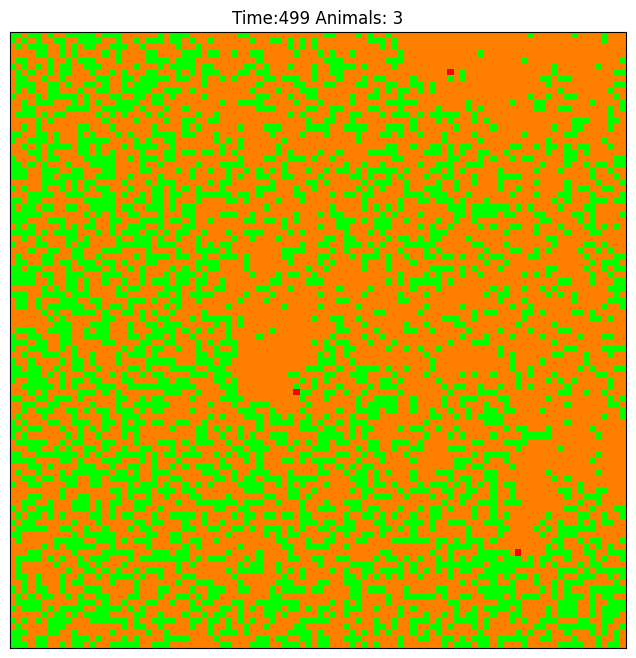

In [44]:
ecosystem1 = EcosystemModel(100, 10, plant_density=0.1, growth_chance=0.001, max_weight=10)
ecosystemAnimation = MatrixAnimation(ecosystem1, total_frames=500)
ecosystemAnimation.play_animation(delay=0.1)
plt.show()

### VISULAS

In this code snippet, a simulation of an ecosystem where creatures graze is executed using the EcosystemModel class. The ecosystem is initialized with a 100x100 grid, a plant density of 0.5, a growth chance of 0.009, and a maximum creature population of 20.

The simulation then progresses through 50 cycles, with each cycle comprising 100 updates of the EcosystemModel.

During each cycle, information regarding the number of surviving creatures, the proportion of the grid covered by plants, and the cycle number is gathered. This data is then saved in the lists creature_data, plant_data, and time_steps, respectively.

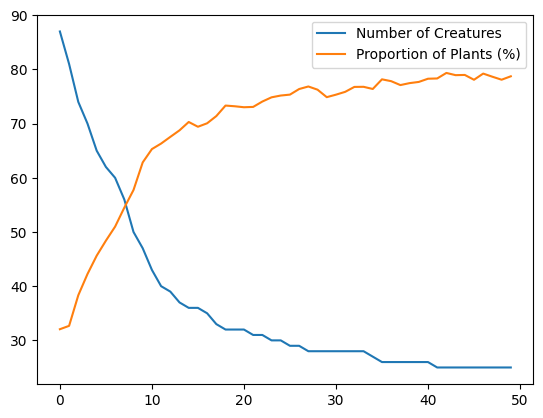

In [37]:
ecosystem2 = EcosystemModel(100, 100, plant_density=0.5, growth_chance=0.009, max_weight=20)
creature_data = []
plant_data = []
time_steps = []
for step in range(50):
    for _ in range(100):
        ecosystem2.update()
    creature_data.append(ecosystem2.surviving_animals())
    plant_data.append(ecosystem2.grass_coverage())
    time_steps.append(step)

fig = plt.figure()
ax = plt.axes()

# Plotting the data
ax.plot(time_steps, creature_data, label='Number of Creatures')
ax.plot(time_steps, plant_data, label='Proportion of Plants (%)')

# Adding a legend
plt.legend()

# Displaying the plot
plt.show()

### Observations and Predictions Based on the Ecosystem Simulation


*   Stability in Creature Population with Increased Plant Density: As the density of plants rises, the decline rate of the creature population stabilizes. This stabilization occurs because more food becomes available, enhancing the survival prospects of the remaining creatures.
*   Interdependence of Creature and Plant Populations: A noticeable trend is the inverse relationship between the creature and plant populations. As the number of creatures dwindles, the coverage of plants expands. Nevertheless, this expansion of plant coverage decelerates over time, indicating a dynamic equilibrium being approached.


Population Dynamics:


1.   The creature population graph exhibits a concave upward trajectory, signaling a rapid initial decrease that gradually slows. This pattern suggests an adjustment period where the surviving population begins to stabilize in response to the slowly increasing plant density.
2.   Conversely, the plant density graph demonstrates a concave downward shape, indicative of a swift initial increase in plant coverage that gradually plateaus. This reflects the diminishing impact of a decreasing creature population on plant regeneration rates.


3. Complex Interplay: The simulations highlight a nuanced interaction between creature and plant populations, where shifts in one significantly impact the other. For instance, a diminishing creature population leads to increased plant coverage, potentially setting the stage for a resurgence in the creature population.

4. Simplistic Model with Deep Insights: Although this model simplifies the complex realities of an ecosystem by not accounting for all potential influencing factors, it offers profound insights into the basic dynamics governing the relationship between creature and plant populations. It underscores the delicate balance and feedback loops inherent in natural ecosystems.

### Comparative Analysis of Different Model Scenarios

1. Methodology: Four instances of the EcosystemModel class are created, each with unique configurations of plant density and growth chance. A function, create_data, simulates each model over 500 cycles to capture the evolving plant coverage and creature count.
2. Visualization: The outcomes are displayed in a 2x2 subplot grid, with each plot detailing the simulation results for a specific model configuration. These plots provide a temporal snapshot of both plant density and creature count, facilitating a direct comparison of how different parameters influence ecosystem dynamics.
3. Objective: The primary aim is to elucidate the ramifications of varying parameter values on the EcosystemModel, offering a visual and analytical comparison. This comparison not only illustrates the direct impacts of these parameters on model behavior but also aids in understanding broader ecological principles that govern real-world ecosystems.

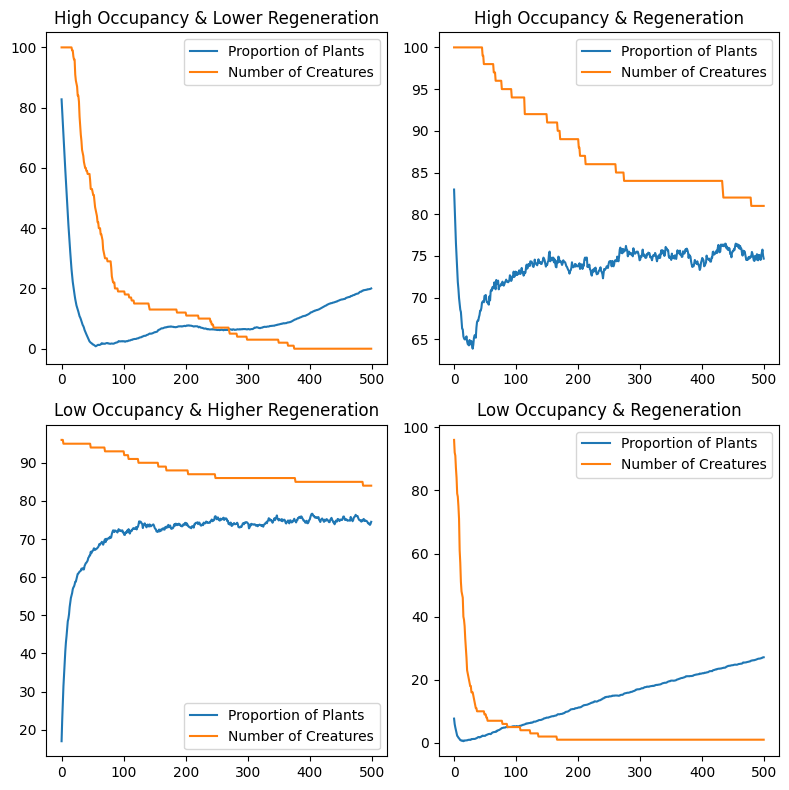

In [39]:
ecosystem3 = EcosystemModel(50, 100, plant_density=0.9, growth_chance=0.001, max_weight=20)
ecosystem4 = EcosystemModel(50, 100, plant_density=0.1, growth_chance=0.1, max_weight=20)
ecosystem5 = EcosystemModel(50, 100, plant_density=0.9, growth_chance=0.1, max_weight=20)
ecosystem6 = EcosystemModel(50, 100, plant_density=0.1, growth_chance=0.001, max_weight=20)

# Prepare x-axis for the plot
x_axis = [i for i in range(500)]

# Function to create data for plotting
def create_data(model, steps):
    grass_percentage = []
    live_creatures = []
    for _ in range(steps):
        model.update()
        grass_percentage.append(model.grass_coverage())
        live_creatures.append(model.surviving_animals())
    return grass_percentage, live_creatures

fig, axes = plt.subplots(2, 2, figsize=(8, 8))

# High occupancy and lower regeneration
data_eco3 = create_data(ecosystem3, 500)
axes[0, 0].plot(x_axis, data_eco3[0], label='Proportion of Plants')
axes[0, 0].plot(x_axis, data_eco3[1], label='Number of Creatures')
axes[0, 0].set_title("High Occupancy & Lower Regeneration")
axes[0, 0].legend()

# Low occupancy and higher regeneration
data_eco4 = create_data(ecosystem4, 500)
axes[1, 0].plot(x_axis, data_eco4[0], label='Proportion of Plants')
axes[1, 0].plot(x_axis, data_eco4[1], label='Number of Creatures')
axes[1, 0].set_title("Low Occupancy & Higher Regeneration")
axes[1, 0].legend()

# High occupancy and regeneration
data_eco5 = create_data(ecosystem5, 500)
axes[0, 1].plot(x_axis, data_eco5[0], label='Proportion of Plants')
axes[0, 1].plot(x_axis, data_eco5[1], label='Number of Creatures')
axes[0, 1].set_title("High Occupancy & Regeneration")
axes[0, 1].legend()

# Low occupancy and regeneration
data_eco6 = create_data(ecosystem6, 500)
axes[1, 1].plot(x_axis, data_eco6[0], label='Proportion of Plants')
axes[1, 1].plot(x_axis, data_eco6[1], label='Number of Creatures')
axes[1, 1].set_title("Low Occupancy & Regeneration")
axes[1, 1].legend()

fig.tight_layout()
plt.show()

### Cellular Automata (CA) are fascinating computational models used to simulate complex systems with simple rules applied over discrete grids of cells. Each cell in a Cellular Automaton can adopt one of several possible states, and the state of each cell in the next "generation" or time step depends on the current states of neighboring cells, according to a set of rules. This makes CAs powerful tools for studying a wide range of phenomena, from physical and biological processes to traffic flow and urban development.

### Algorithm 1: Naive Iteration
Description: A straightforward way to implement a CA is by iterating through each cell in the grid for every generation. For each cell, the algorithm checks the states of its neighbors and applies the CA rules to determine the next state.

Time Complexity Analysis:
For each generation, every cell in the n x m grid is examined.
The examination of each cell involves looking at a fixed number of neighbors. For simplicity, consider this a constant time operation, regardless of the rule complexity (since the number of neighbors is limited and does not scale with the grid size).
Thus, for a single generation, the operation is
O
(
n
m
)
O(nm).
For
t
t generations, the time complexity becomes
O
(
t
⋅
n
m
)
O(t⋅nm).
This method is simple and easy to implement but can become inefficient for very large grids or a high number of generations due to its direct proportionality to both grid size and the number of generations.



In [41]:
my_code = '''
def seek_food(self, environment):
    # Retrieve the creature's current location
    current_x, current_y = self.location

    # Identify the locations of all plants in the environment
    plant_positions = np.argwhere(environment == EcosystemModel.PLANT)
    # Calculate Euclidean distances from the creature to all plants
    distances = np.sqrt(np.sum((plant_positions - self.location) ** 2, axis=1))

    # Determine the closest plant and move towards it
    closest_plant_index = np.argmin(distances)
    closest_plant_location = tuple(plant_positions[closest_plant_index])
    direction_x, direction_y = np.sign(closest_plant_location[0] - current_x), np.sign(closest_plant_location[1] - current_y)

    # Calculate new location, considering wrapping at grid edges
    new_location_x = (current_x + direction_x) % environment.shape[0]  # Adjust for grid width
    new_location_y = (current_y + direction_y) % environment.shape[1]  # Adjust for grid height
    new_location = (new_location_x, new_location_y)
    return new_location
'''
print(timeit.timeit(stmt =my_code))

0.09349043500014886


### Algorithm 2: Using Additional State Information
Description: An optimized approach can involve storing additional state information or utilizing more complex data structures to reduce redundant calculations. For example, one might keep track of changes in cell states or use a queue to process only cells that need updating based on the previous generation's changes.

Time Complexity Analysis:
Assuming the optimized method significantly reduces the number of cells to be processed by only focusing on cells that might change (e.g., cells at or near the boundary of different state regions), the average number of cells processed per generation could be lower.
Let
k
k be the average number of cells that need to be checked per generation, where
k
<
n
m
k<nm and depends on the specific optimization and CA rules.
The time complexity for a single generation becomes
O
(
k
)
O(k), and for
t
t generations, it is
O
(
t
⋅
k
)
O(t⋅k).
The exact value of
k
k and therefore the practical efficiency gain depends heavily on the CA's rules and initial conditions.
Considerations:

The actual performance and time complexity can vary widely depending on the specifics of the CA rules, the initial state of the grid, and how changes propagate through the system.
The naive iteration method is more universally applicable but less efficient for large-scale simulations or where only a small portion of the grid changes state frequently.
Optimizations that reduce the number of cells processed each generation can significantly improve performance but might require more complex implementation and depend on the nature of the CA rules and states.
In conclusion, the choice of algorithm and its implementation for simulating Cellular Automata should be influenced by the specific requirements and characteristics of the simulation, including grid size, the complexity of rules, and the need for speed versus simplicity in the implementation.

In [42]:
my_code='''
def update_ecosystem(self):
    # Find positions of all alive creatures
    alive_creatures_positions = [creature.location for creature in self.creatures if creature.alive]

    # Assuming get_neighbors_8 and get_closest_plant_positions are defined
    # Get neighboring positions for all creatures
    neighbor_positions = np.array(get_neighbors_8(self.environment))

    # Find indices of alive creatures in the neighbor positions array
    alive_creatures_indices = np.where(np.isin(neighbor_positions, alive_creatures_positions).all(axis=2))

    # Get positions of the closest plant for all creatures
    closest_plant_positions = get_closest_plant_positions(self.environment, alive_creatures_positions)

    # Update weight and status for all creatures
    for i, creature in enumerate(self.creatures):
        if not creature.alive:
            continue
        creature.update_weight_vectorized(self.environment, closest_plant_positions[i])
        creature.update_status()
        if not creature.alive:
            continue
        self.environment[creature.location] = self.EMPTY
        self.environment[closest_plant_positions[i]] = self.CREATURE
        creature.location = closest_plant_positions[i]

    # Regrow plants
    regrowing_plants = (self.environment == self.EMPTY) & (np.random.random(self.environment.shape) < self.growth_chance)
    self.environment[regrowing_plants] = self.PLANT'''
print(timeit.timeit(stmt =my_code))


0.14089497299983123


### Implementing caching to store previously calculated distances in the context of creatures seeking plants in an ecosystem model does not alter the Big-O time complexity of the algorithm but optimizes its efficiency by reducing computational overhead. Such an approach can lead to significant performance improvements, especially in scenarios where multiple creatures occupy the same or nearby positions and thus share similar distance calculations.

### Impact on Big-O Time Complexity
The Big-O time complexity remains unchanged because the fundamental operations that determine the algorithm's scalability with respect to the input size are not altered by caching. Specifically, the time complexity related to examining the neighboring cells around each creature (or deer in the original context) and identifying the closest plant remains
O
(
n
)
O(n), where
n
n represents the total number of cells that must be inspected. Caching optimizes how often these operations are performed but does not change the algorithm's inherent complexity class.

### Impact on Performance
The caching mechanism optimizes the algorithm's performance in two significant ways:

### Reduction of Multiplicative Coefficient (Linear Improvement): By avoiding redundant distance calculations for creatures in the same or similar positions, caching directly reduces the number of operations required per creature. This linear improvement affects the slope of the time complexity curve, making the algorithm more efficient within its complexity class.

### Reduction of Constant Factor (Overhead): Initial setup of the cache, along with the logic to check and retrieve pre-calculated distances, adds some overhead. However, the overall impact of this overhead is mitigated by the substantial savings from not recalculating distances, especially in dense ecosystems where creatures frequently occupy similar locations. The overhead becomes a relatively small and justified expense for the performance gains achieved.

### Practical Benefits
Efficiency in Dense Ecosystems: In scenarios where creatures cluster in particular regions of the environment, the caching mechanism significantly reduces the computational load by leveraging shared calculations.
Vectorized Operations: Utilizing NumPy's vectorized operations to handle distance calculations and other related computations further enhances performance by exploiting efficient, low-level optimizations and parallelism where possible.

###In summary, while the caching strategy and the use of vectorized operations do not change the algorithm's Big-O time complexity, they provide substantial linear improvements and reduce overhead, making the algorithm more efficient in practice. These optimizations are particularly beneficial in simulations involving a large number of entities or in high-density scenarios, where they can lead to significant speedups.